In [1]:
from torchvision import datasets, transforms
from skimage.color import rgb2lab, rgb2gray, lab2rgb
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import cv2
%matplotlib inline
scale_transform = transforms.Compose([
    transforms.Scale(256),
    #transforms.RandomCrop(224),
    #transforms.ToTensor()
])


class TrainImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)

            img_lab = rgb2lab(img_original)

            img_lab = (img_lab + 128) / 255

            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1)))
            img_original = rgb2gray(img_original)
            img_original = torch.from_numpy(img_original)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return (img_original, img_ab), target


class ValImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        
        gr_t = img.copy()
        img_scale = img.copy()
        img_original = img
        img_scale = scale_transform(img_scale)
        
        #img_original = scale_transform(img_original) #uncomment for my photos
        
        img_scale = np.asarray(img_scale)
        img_original = np.asarray(img_original)
        gr_t = np.asarray(gr_t)
       
        img_scale = rgb2gray(img_scale)
        img_scale = torch.from_numpy(img_scale)
        img_original = rgb2gray(img_original)
        img_original = torch.from_numpy(img_original)
        gr_t = torch.from_numpy(gr_t)
        return (img_original, img_scale, gr_t), target

/home/n.begunov/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class LowLevelFeatNet(nn.Module):
    def __init__(self):
        super(LowLevelFeatNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)

    def forward(self, x1, x2):
        x1 = F.relu(self.bn1(self.conv1(x1)))
        x1 = F.relu(self.bn2(self.conv2(x1)))
        x1 = F.relu(self.bn3(self.conv3(x1)))
        x1 = F.relu(self.bn4(self.conv4(x1)))
        x1 = F.relu(self.bn5(self.conv5(x1)))
        x1 = F.relu(self.bn6(self.conv6(x1)))
        if self.training:
            x2 = x1.clone()
        else:
            x2 = F.relu(self.bn1(self.conv1(x2)))
            x2 = F.relu(self.bn2(self.conv2(x2)))
            x2 = F.relu(self.bn3(self.conv3(x2)))
            x2 = F.relu(self.bn4(self.conv4(x2)))
            x2 = F.relu(self.bn5(self.conv5(x2)))
            x2 = F.relu(self.bn6(self.conv6(x2)))
        return x1, x2


class MidLevelFeatNet(nn.Module):
    def __init__(self):
        super(MidLevelFeatNet, self).__init__()
        self.conv1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x


class GlobalFeatNet(nn.Module):
    def __init__(self):
        super(GlobalFeatNet, self).__init__()
        self.conv1 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(25088, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn7 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(-1, 25088)
        x = F.relu(self.bn5(self.fc1(x)))
        output_512 = F.relu(self.bn6(self.fc2(x)))
        output_256 = F.relu(self.bn7(self.fc3(output_512)))
        #x = F.relu(self.fc1(x))
        #output_512 = F.relu(self.fc2(x))
        #output_256 = F.relu(self.fc3(output_512))
        return output_512, output_256


class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 205)
        self.bn2 = nn.BatchNorm1d(205) #365

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.log_softmax(self.bn2(self.fc2(x)))
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x))
        return x


class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.conv1 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.UpsamplingNearest2d(scale_factor=2)

    def forward(self, mid_input, global_input):
        w = mid_input.size()[2]
        h = mid_input.size()[3]
        global_input = global_input.unsqueeze(2).unsqueeze(2).expand_as(mid_input)
        fusion_layer = torch.cat((mid_input, global_input), 1)
        fusion_layer = fusion_layer.permute(2, 3, 0, 1).contiguous()
        fusion_layer = fusion_layer.view(-1, 512)
        fusion_layer = self.bn1(self.fc1(fusion_layer))
        fusion_layer = fusion_layer.view(w, h, -1, 256)

        x = fusion_layer.permute(2, 3, 0, 1).contiguous()
        x = F.relu(self.bn2(self.conv1(x)))
        x = self.upsample(x)
        x = F.relu(self.bn3(self.conv2(x)))
        x = F.relu(self.bn4(self.conv3(x)))
        x = self.upsample(x)
        x = F.sigmoid(self.bn5(self.conv4(x)))
        x = self.upsample(self.conv5(x))
        return x

class ColorizationNetBaseline(nn.Module):
    def __init__(self):
        super(ColorizationNetBaseline, self).__init__()
        self.conv0 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(1024, 128, kernel_size=3, stride=1, padding=1) #256
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
        
    def forward(self, mid_input, low_input):
        mid_input_pr = self.conv0(mid_input)
        x = torch.cat((mid_input_pr, low_input), 1)#1
        x = F.relu(self.bn2(self.conv1(x)))
        x = self.upsample(x)
        x = F.relu(self.bn3(self.conv2(x)))
        x = F.relu(self.bn4(self.conv3(x)))
        x = self.upsample(x)
        x = F.sigmoid(self.bn5(self.conv4(x)))
        x = self.upsample(self.conv5(x))
        return x
        
    
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        self.low_lv_feat_net = LowLevelFeatNet()
        self.mid_lv_feat_net = MidLevelFeatNet()
        self.global_feat_net = GlobalFeatNet()
        self.class_net = ClassificationNet()
        self.upsample_col_net = ColorizationNet()

    def forward(self, x1, x2):
        x1, x2 = self.low_lv_feat_net(x1, x2)       
        x1 = self.mid_lv_feat_net(x1)        
        class_input, x2 = self.global_feat_net(x2)        
        class_output = self.class_net(class_input)        
        output = self.upsample_col_net(x1, x2)        
        return class_output, output
    
    
    
class ColorNetBaseline(nn.Module):
    def __init__(self):
        super(ColorNetBaseline, self).__init__()
        self.low_lv_feat_net = LowLevelFeatNet()
        self.mid_lv_feat_net = MidLevelFeatNet()
        #self.global_feat_net = GlobalFeatNet()
        #self.class_net = ClassificationNet()
        self.upsample_col_net = ColorizationNetBaseline()

    def forward(self, x1, x2):
        x1, x2 = self.low_lv_feat_net(x1, x2)
  
        x1 = self.mid_lv_feat_net(x1)
        #class_input, x2 = self.global_feat_net(x2)
        #class_output = self.class_net(class_input)
        output = self.upsample_col_net(x1, x2)
      
        return output

In [3]:
CUDA_DEVICE = 3

In [ ]:
import os
import traceback

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
import numpy as np



original_transform = transforms.Compose([
    transforms.Scale(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    #transforms.ToTensor()
])

have_cuda = torch.cuda.is_available()
#CUDA_DEVICE = 0
epochs = 1

data_dir = "./places365_standard/train/"
train_set = TrainImageFolder(data_dir, original_transform)
train_set_size = len(train_set)
train_set_classes = train_set.classes
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
color_model = ColorNetBaseline()
if os.path.exists('./model.ckpt'):
    color_model.load_state_dict(torch.load('model.ckpt', map_location=lambda storage, loc: storage.cuda(CUDA_DEVICE)))
if have_cuda:
    color_model.cuda(CUDA_DEVICE)
optimizer = optim.Adadelta(color_model.parameters())
mse = nn.MSELoss()
#cross_entropy = nn.CrossEntropyLoss()
losses = []
for epoch in range(epochs):
    
    for batch_idx, (data, classes) in enumerate(train_loader):
        
        
        original_img = data[0].unsqueeze(1).float()
        img_ab = data[1].float()
        if have_cuda:
            original_img = original_img.cuda(CUDA_DEVICE)
            img_ab = img_ab.cuda(CUDA_DEVICE)
            classes = classes.cuda(CUDA_DEVICE)
            
        original_img = Variable(original_img)
        img_ab = Variable(img_ab)
        classes = Variable(classes)
        
        optimizer.zero_grad()
        output = color_model(original_img, original_img) #+class_output
        #ems_loss = torch.pow((img_ab - output), 2).sum() / torch.from_numpy(np.array(list(output.size()))).prod()
        #cross_entropy_loss = 1/300 * F.cross_entropy(class_output, classes)
        ems_loss = F.mse_loss(img_ab, output)
        #cross_entropy_loss = F.cross_entropy(class_output, classes)
        loss = ems_loss #+ cross_entropy_loss
       
        ems_loss.backward(retain_variables = True)#retain_variables = True
        #cross_entropy_loss.backward(retain_graph=True)
        optimizer.step()
        
        if batch_idx % 500 == 0:
           
            torch.save(color_model.state_dict(),'model.ckpt')
            losses.append(loss.data[0])
            print('Train Epoch: {}[{}/{}({:.0f}%)]\tLoss: {:.9f}\n'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                         100. * batch_idx / len(train_loader), loss.data[0]))

/home/n.begunov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:133: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


Result:


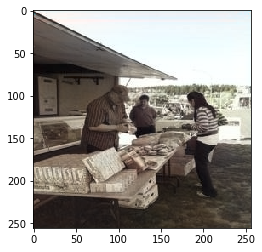

Ground Truth:


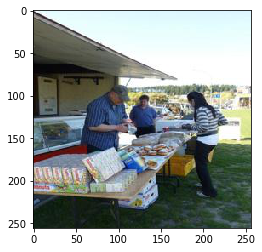

Result:


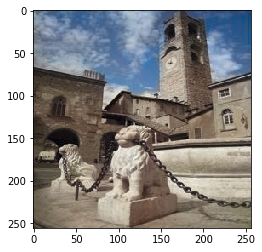

Ground Truth:


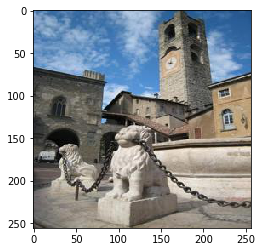

Result:


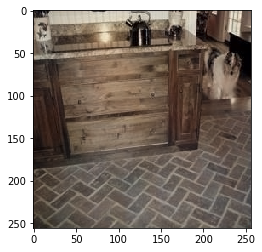

Ground Truth:


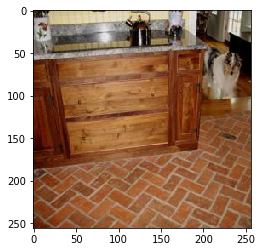

Result:


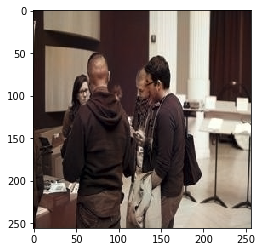

Ground Truth:


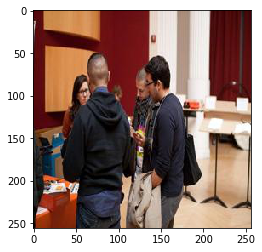

In [10]:
import os

import torch
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image
from skimage.color import lab2rgb
from skimage import io

import numpy as np
import matplotlib.pyplot as plt

#CUDA_DEVICE = 1
data_dir = "./places365_standard/val/" #my_pictures is for my photos
how_many_pictures_i_want_to_see = 5
have_cuda = torch.cuda.is_available()

val_set = ValImageFolder(data_dir)
val_set_size = len(val_set)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True, num_workers=1)

color_model = ColorNetBaseline()
color_model.load_state_dict(torch.load('model.ckpt', map_location=lambda storage, loc: storage.cuda(CUDA_DEVICE)))
if have_cuda:
    color_model.cuda(CUDA_DEVICE)


def val():
    color_model.eval()

    i = 0
    for data, _ in val_loader:
        
        if i==how_many_pictures_i_want_to_see-1:
            break
        
        original_img = data[0].unsqueeze(1).float()
        
        for img in original_img:
            pic = img.squeeze().numpy()
            pic = pic.astype(np.float64)
           
        w = original_img.size()[2]
        h = original_img.size()[3]
        scale_img = data[1].unsqueeze(1).float()
        ground_truth = data[2].squeeze(0).float().numpy().astype(np.int32)
        
        if have_cuda:
            original_img, scale_img = original_img.cuda(CUDA_DEVICE), scale_img.cuda(CUDA_DEVICE)
            
        original_img, scale_img = Variable(original_img, volatile=True), Variable(scale_img)        
        output = color_model(original_img, scale_img)

        color_img = torch.cat((original_img, output[:, :, 0:w, 0:h]), 1)
        color_img = color_img.data.cpu().numpy().transpose((0, 2, 3, 1))
        
        for img in color_img:
            img[:, :, 0:1] = img[:, :, 0:1] * 100
            img[:, :, 1:3] = img[:, :, 1:3] * 255 - 128
            img = img.astype(np.float64)
            img = lab2rgb(img)

            print('Result:')
            plt.imshow(img)
            plt.show()
            print('Ground Truth:')
            plt.imshow(ground_truth)
            plt.show()
            i += 1

val()